In [1]:
# Initial imports and variable definitions
import os
import re
import glob
import string
import datetime
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
from afinn import Afinn
import matplotlib.pyplot as plt
import scipy as sc
from empath import Empath

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

DATA_DIR = "../data/"
ASSETS_DIR = "../assets/"

This notebook consists of two parts:
- analysis of the quotes related to the top movies
- some visualisations

## 1. Load Data

In [2]:
# Load the quotes that mention the top 50 movies
# Generated in mergeDataSets/linkQuotesToMovies.ipynb
quotes = pd.read_csv(DATA_DIR + "50moviesquotes.csv.gz")

The first cleaning stage will consit in removing from the quotes the title of the movies (otherwise the study will have a high bias)

In [3]:
# The list of movies for which the quotes have been extracted from the full quote dataset
alttitles = dict([
    ('Star Wars: Episode VII - The Force Awakens', ['Star Wars', 'The force awakens']),
    ('Avengers: Endgame', ['Avengers', 'Endgame']),
    ('Black Panther', ['Black Panther']),
    ('Avengers: Infinity War', ['Infinity War', 'Avengers']),
    ('Jurassic World', ['Jurassic']), # Probably a bad idea but let's see
    ('Star Wars: Episode VIII - The Last Jedi', ['Star Wars', 'Last Jedi']),
    ('Incredibles 2', ['Incredibles']), # Possibly too broad
    ('The Lion King', ['Lion King']),
    ('Rogue One: A Star Wars Story', ['Rogue One', 'Star Wars']),
    ('Star Wars: Episode IX - The Rise of Skywalker', ['Star Wars', 'Skywalker']),
    ('Beauty and the Beast', ['Beauty and the Beast']),
    ('Finding Dory', ['Finding Dory']),
    ('Frozen II', ['Frozen']), # Probably a bad idea but let's see
    ('Avengers: Age of Ultron', ['Avengers', 'Ultron']),
    ('Toy Story 4', ['Toy Story']),
    ('Captain Marvel', ['Marvel']),
    ('Jurassic World: Fallen Kingdom', ['Jurassic', 'Fallen Kingdom']),
    ('Captain America: Civil War', ['Captain America', 'Civil War']),
    ('Jumanji: Welcome to the Jungle', ['Jumanji', 'Welcome to the Jungle']),
    #('Spider-Man: Far from Home', ['Spider-Man', 'Spider Man', 'Far from Home']),
    ('Guardians of the Galaxy Vol. 2', ['Guardians of the Galaxy']),
    ('The Secret Life of Pets', ['Secret Life of Pets']),
    ('The Jungle Book', ['Jungle Book']),
    ('Deadpool', ['Deadpool']),
    ('Inside Out', ['Inside Out']),
    ('Aladdin', ['Aladdin']),
    ('Furious 7', ['Furious']), # Probably a bad idea but let's see
    ('American Sniper', ['American Sniper']),
    ('Zootopia', ['Zootopia']),
    ('The Hunger Games: Mockingjay - Part 1', ['Hunger Games', 'Mockingjay']),
    ('Minions', ['Minions']), # Possibly too broad
    ('Joker', ['Joker']),
    ('Aquaman', ['Aquaman']),
    ('Spider-Man: Homecoming', ['Spider-Man', 'Spider Man', 'Homecoming']),
    ('Batman v Superman: Dawn of Justice', ['Batman', 'Superman', 'Dawn of Justice']),
    #('It', []), # just not possible
    ('Suicide Squad', ['Suicide Squad']),
    ('Jumanji: The Next Level', ['Jumanji', 'The Next Level']),
    ('Deadpool 2', ['Deadpool']),
    ('Thor: Ragnarok', ['Thor', 'Ragnarok']),
    ('The Hunger Games: Mockingjay - Part 2', ['Hunger Games', 'Mockingjay']),
    ('The Grinch', ['Grinch']),
    ('Sing', ['Sing']), # Probably a bad idea but let's see
    ('Despicable Me 3', ['Despicable Me']),
    ('The Hobbit: The Battle of the Five Armies', ['Hobbit', 'Battle of the Five Armies']),
    ('Moana', ['Moana']),
    ('Fantastic Beasts and Where to Find Them', ['Fantastic Beasts']),
    ('Doctor Strange', ['Doctor Strange']),
    ('Justice League', ['Justice League'])
])

In [4]:
# Remove title and search keys from quotations
# To avoid self inference
# ie. the title "Fast and furious" counts negatively, while it's just the title
for movie in alttitles:
    for strt in alttitles[movie]:
        val = quotes.loc[quotes["primaryTitle"] == movie]["quotation"].str.replace(strt, '', case=False)
        quotes.loc[quotes["primaryTitle"] == movie, "quotation"] = val

Cleaning the movie data set

In [5]:
# Load the boxoffice, see movieBoxOffice.ipynb to generate the dataset
boxoffice = pd.read_csv(DATA_DIR + "boxoffice.csv")

# And do some clean up of the data (ie. map the boxoffice value to a readable int)
boxoffice["boxoffice"] = boxoffice["Gross"].apply(lambda x:int(x.replace("$","").replace(",", "")))
boxoffice["% of Total"] = pd.to_numeric(boxoffice["% of Total"].str.replace("%",""), errors="coerce")

Merging quotes and boxoffice data

In [6]:
# Merge quotes and boxoffice
quotes = pd.merge(left=quotes, right=boxoffice, how="left", left_on="primaryTitle", right_on="Release")

# Add a field to count days between quote and release date
quotes["diff_date"] = (pd.to_datetime(quotes["date"]) - pd.to_datetime(quotes["Release Date"])).dt.days

# Only keep a time window around the release date
DELTA_T = 10
quotes = quotes[(quotes["diff_date"] < DELTA_T) & (quotes["diff_date"] > -DELTA_T)]

## 2. Sentiment polarity

In [7]:
afn = Afinn()
nlp = en_core_web_sm.load()

punctuations = string.punctuation
#stopwords = list(STOP_WORDS)

parser = nlp
# Tokenize the given sentence
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in punctuations ]
    tokens = " ".join([i for i in tokens])
    return tokens

# Returns the number of words in the sentence
def count_words(s):
    return len(s.split())

# Returns the sentiment score of the given sentence
def sentiment(s):
    return afn.score(s)

In [8]:
# Apply the tokenizer on the set of quotes
# This is relatively long to run (~15min)
quotes["text_clean"] = quotes["quotation"].apply(spacy_tokenizer)
quotes["text"] = quotes["text_clean"].astype('str')

In [9]:
# Extract the sentiment score from the set of quotes
quotes["sentiment"] = quotes["text"].apply(sentiment)
quotes["word_counts"] = quotes["text"].apply(count_words)

In [10]:
# Export the dataset containg the sentiment score
quotes.to_csv(DATA_DIR + "50movies_sentiment_polarity.csv.gz",compression="gzip")

This dataset can be found at https://drive.google.com/drive/folders/1Kwv7boEYxS1DRev6KCIJLhoYiBRBMHUV?usp=sharing, to avoid having to run everything back again.

## 3. Emotion Analysis

In [11]:
# Get the sentiment from each quote
# Long to run ~25min

lexicon = Empath()
categories = ["warmth", "fun", "love", "emotional", "disappointment","hate"]
results=[]
analysis = pd.DataFrame(columns=["primaryTitle", "% of Total", "sentiment", "score"])

for index, row in quotes.iterrows():
    experience = lexicon.analyze(row["text"],categories = categories)
    
    for cat in experience:
        analysis = analysis.append({
            "primaryTitle": row["primaryTitle"],
            "% of Total": row["% of Total"],
            "sentiment": cat,
            "score": experience[cat]
        },ignore_index=True)

analysis.head(10)

,primaryTitle,% of Total,sentiment,score
0,Star Wars: Episode VII - The Force Awakens,26.5,warmth,0.0
1,Star Wars: Episode VII - The Force Awakens,26.5,fun,0.0
2,Star Wars: Episode VII - The Force Awakens,26.5,love,0.0
3,Star Wars: Episode VII - The Force Awakens,26.5,emotional,0.0
4,Star Wars: Episode VII - The Force Awakens,26.5,disappointment,0.0
5,Star Wars: Episode VII - The Force Awakens,26.5,hate,0.0
6,Star Wars: Episode VII - The Force Awakens,26.5,warmth,0.0
7,Star Wars: Episode VII - The Force Awakens,26.5,fun,0.0
8,Star Wars: Episode VII - The Force Awakens,26.5,love,0.0
9,Star Wars: Episode VII - The Force Awakens,26.5,emotional,0.0


In [12]:
# Export the produced dataset
analysis.to_csv(DATA_DIR + "50movies_sentiment_emotion.csv.gz",compression="gzip")

This dataset can be found at https://drive.google.com/drive/folders/1Kwv7boEYxS1DRev6KCIJLhoYiBRBMHUV?usp=sharing, to avoid having to run everything back again.

## 4. Visualizations

Reload the data since previous stages are time consuming (40min)

In [13]:
# Load boxoffice, see movieBoxOffice.ipynb to generate the dataset
boxoffice = pd.read_csv("../data/boxoffice.csv")
boxoffice["boxoffice"] = boxoffice["Gross"].apply(lambda x:int(x.replace("$","").replace(",","")))
boxoffice["% of Total"] = pd.to_numeric(boxoffice["% of Total"].str.replace("%",""),errors="coerce")

# Load sentiment analysis and sentiment polarity datasets
analysis = pd.read_csv(DATA_DIR + "50movies_sentiment_emotion.csv.gz")
polarity = pd.read_csv(DATA_DIR + "50movies_sentiment_polarity.csv.gz")

# Remove movies with too much unrelated quotes (ie. Sing)
analysis = analysis[analysis["primaryTitle"] != "Sing"]
polarity = polarity[polarity["primaryTitle"] != "Sing"]

### Emotion analysis

1. Split the movies into 3 categories, depending on whether they had a good first week boxoffice result

In [15]:
# Split the movies into 3 categories
# depending on whether they had a good first week
# boxoffice revenue

name1 = "high % first WE"
name2 = "intermediate score"
name3 = "high % after first WE"

boxoffice["category"] = (boxoffice["% of Total"] < boxoffice["% of Total"].quantile(q=1/3)) * 1 + \
                        (boxoffice["% of Total"] < boxoffice["% of Total"].quantile(q=2/3)) * 1

boxoffice.loc[boxoffice["category"]==0,"category"] = name1
boxoffice.loc[boxoffice["category"]==1,"category"] = name2
boxoffice.loc[boxoffice["category"]==2,"category"] = name3

# Aggregate by movie and sentiment type
analysis2 = analysis.groupby(["primaryTitle", "sentiment"]).agg(score=("score", "mean"),
                                                                count=("primaryTitle", "count")).reset_index()
# Keep only if there are at least 20 elements
analysis2 = analysis2[analysis2["count"] > 20]

# Incorporate movie data
analysis3 = pd.merge(left=analysis2,
                     right=boxoffice[["Release","category"]],
                     how="left",
                     left_on="primaryTitle",
                     right_on="Release")

2. Plot average score of various sentiment types

p-value for the t-test for warmth: 0.47549362568244724
p-value for the t-test for fun: 0.6514577162563874
p-value for the t-test for love: 0.11420706807757429
p-value for the t-test for emotional: 0.07455874331666544
p-value for the t-test for disappointment: 0.8006170811370565
p-value for the t-test for hate: 0.031676437110225


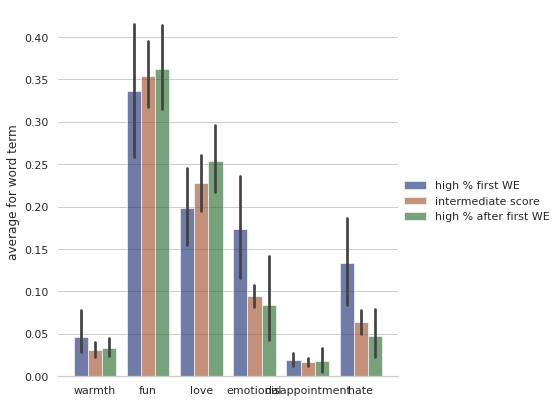

In [16]:
# Plot the average sentiment score of various sentiment types,
# splitted depending on whether the movie had a good result
# during the first week

sns.set_theme(style="whitegrid")

analysis3.sort_values("category")
g = sns.catplot(
    data=analysis3, kind="bar", x="sentiment", y="score",
    hue="category", palette="colorblind", alpha=.6, height=6,
    hue_order=[name1,name2,name3], order=categories
)

g.despine(left=True)
g.set_axis_labels("", "average for word term")
g.legend.set_title("")
# Export the plot produced
plt.savefig(ASSETS_DIR + "sentimentAnalysis.pdf")
plt.savefig(ASSETS_DIR + "sentimentAnalysis.png")
plt.plot()

# Compute the t-test
for cat in categories:
    a1 = analysis3[(analysis3["sentiment"] == cat) & (analysis3["category"] == name1)]["score"]
    a2 = analysis3[(analysis3["sentiment"] == cat) & (analysis3["category"] == name3)]["score"]
    res = sc.stats.ttest_ind(a1,a2)
    print(f"p-value for the t-test for {cat}: {res[1]}")

### Polarity

In [42]:
# Some functions and variables to plot easily later

# The split 
s1 = 100
s2 = 300
labels = [f"# quotes <{s1}",f"# quotes in [{s1},{s2}]",f"# quotes >{s2}"]

# specify colors manually so that the same column always has the same color
# choose colorblind-friendly colors according to 
# https://davidmathlogic.com/colorblind
palette=[["#FFC20A"], ["#0C7BDC"], ["#D41159"]]

def handle_grouped_quotes(quotes_gr):
    # Filter low count
    quotes_gr = quotes_gr[quotes_gr["count"] > 20].copy()

    quotes_gr["cat"] = (quotes_gr["count"] < s1) * 0 +  \
                       (quotes_gr["count"] >= s1) * 1 + \
                       (quotes_gr["count"] > s2) * 1

    quotes_gr.sort_values("cat")
    return quotes_gr

In [43]:
def handle_plot(quotes_gr, x, xlabel, y, ylabel, exportname):
    plt.figure(figsize=(8, 6))

    # Plot, with a different color for each category
    for i in range(3):
        sns.scatterplot(data=quotes_gr[quotes_gr["cat"] == i],
                        x=x, y=y,
                        s=i * 60 + 100, alpha=1,
                        label=labels[i], c=palette[i])

    # Compute statistical coefficients
    a1 = sc.stats.spearmanr(quotes_gr[x], quotes_gr[y])
    b1 = sc.stats.pearsonr(quotes_gr[x], quotes_gr[y])

    # Set labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Spearman Correlation {a1[0]:.2}, p-value {a1[1]:.3}\n Pearson Correlation {b1[0]:.2}, p-value {b1[1]:.3}")

    # Export the plot produced
    plt.savefig(ASSETS_DIR + exportname + ".pdf")
    plt.savefig(ASSETS_DIR + exportname + ".png")
    
    plt.legend(title='# quotes related to the movie')
    plt.grid(which='major', color='gray', alpha=0.4, linestyle='-')

1. Relation to the total gross

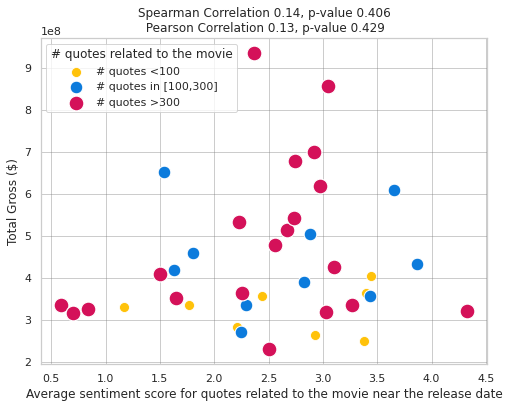

In [44]:
# Plot the relation between the average sentiment score and the total gross

quotes_gr = polarity.groupby("primaryTitle").agg(
    boxoffice=("boxoffice","first"),
    sentiment=("sentiment","mean"),
    count=("boxoffice","count")
).reset_index()

quotes_gr = handle_grouped_quotes(quotes_gr)
xlabel = "Average sentiment score for quotes related to the movie near the release date"
ylabel = "Total Gross ($)"
handle_plot(quotes_gr, "sentiment", xlabel, "boxoffice", ylabel, "polarityAnalysis_totalGross")

2. Relation to perccentage of gross achieved on the first WE

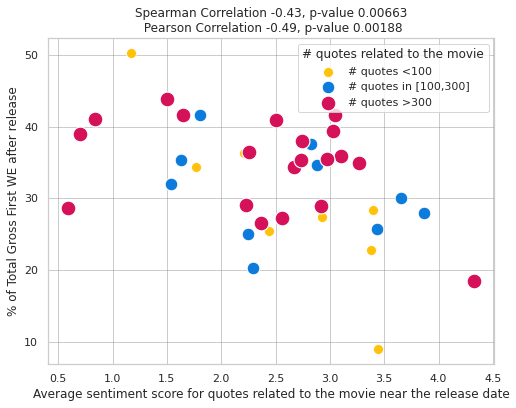

In [45]:
# Plot the relation between the average sentiment score and first week gross

quotes_gr = polarity.groupby("primaryTitle").agg(
    percent=("% of Total","first"),
    sentiment=("sentiment","mean"),
    count=("sentiment","count"),
    boxoffice=("boxoffice","first")
).reset_index()

quotes_gr = handle_grouped_quotes(quotes_gr)
ylabel = "% of Total Gross First WE after release"
handle_plot(quotes_gr, "sentiment", xlabel, "percent", ylabel, "polarityAnalysis_percentGross")